In [1]:
##############################################
# Google Colab Mounting and Data Downloading #
##############################################

# import ziplefile
import zipfile

# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# path to data
data_root = "/content/drive/MyDrive/data.zip"

# unzip data and store in content
with zipfile.ZipFile(data_root, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

Mounted at /content/drive


In [17]:
###########
# Imports #
###########

# install library for unet++
#pip install segmentation_models_pytorch

import sys
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageFilter
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gc
import segmentation_models_pytorch as smp
from torch.nn.functional import conv2d
from tqdm import tqdm
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler



# fix possible truncation during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



###################
#  Local Imports  #
###################

# auto reload for modules (get rid of old caches that cause errors)
%load_ext autoreload
%autoreload 2

# import correct path for project directory
sys.path.append('/content/drive/MyDrive/mech_interp_segmentation')


from dataset import *
from utils import *
from experiments import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#######################
# Load Trained Models #
#######################

# set working directory
working_dir = os.getcwd()

# load model CNN

# set encoder name
encoder_name = 'resnet34'
model_cnn, image_processor_unet=load_model_and_processor_unet(save_dir=(working_dir + '/drive/MyDrive/mech_interp_segmentation/models/unet/unetpp_epoch20_batch16'), encoder_name=encoder_name, num_labels=1)


# load model Transformer
model_transformer, image_processor_transformer = load_model_and_processor_mask2former(working_dir + '/drive/MyDrive/mech_interp_segmentation/models/transformer/mask2former_epoch15_batch16')


# load data
data_root = working_dir + '/data/data/'

# define the loaders
train_loader, val_loader, test_loader, train_images, val_images, test_images, train_masks, val_masks, test_masks = create_dataloaders(data_root, batch_size=16)


model loaded from /content/drive/MyDrive/mech_interp_segmentation/models/unet/unetpp_epoch20_batch16
Model and image processor loaded from /content/drive/MyDrive/mech_interp_segmentation/models/transformer/mask2former_epoch15_batch16


In [5]:
# Candidate layer lists for UNet++ (CNN)
unet_encoder_candidates = [
    "encoder.layer3",  # mid-level encoder features
    "encoder.layer4"   # high-level encoder features
]
unet_decoder_candidates = [
    "decoder.blocks.x_1_1.conv1",  # a decoder block (fine-tuned features)
    "segmentation_head.0"          # final segmentation head output
]

# Candidate layer lists for Mask2Former (Transformer)
mask2former_encoder_candidates = [
    "model.pixel_level_module.encoder.embeddings.norm",  # normalized patch embeddings
    "model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense"  # intermediate high-level features
]
mask2former_decoder_candidates = [
    "model.transformer_module.decoder.mask_predictor.mask_embedder.0.0"  # decoder mask embedder (task-specific)
]

# Combine candidate layers for each model
unet_candidates = unet_encoder_candidates + unet_decoder_candidates
mask2former_candidates = mask2former_encoder_candidates + mask2former_decoder_candidates



# Now run the investigation for both models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move to device
model_cnn.to(device)
model_transformer.to(device)

print("Investigating UNet++ candidate layers:")
investigate_candidate_layers(model_cnn, unet_encoder_candidates + unet_decoder_candidates, val_loader, device)

print("\nInvestigating Mask2Former candidate layers:")
investigate_candidate_layers(model_transformer, mask2former_encoder_candidates + mask2former_decoder_candidates, val_loader, device)


Investigating UNet++ candidate layers:


Extracting features for candidate layers:   0%|          | 0/7 [00:28<?, ?it/s]


Candidate Layers and their Activation Shapes:


Investigating candidate layers: 100%|██████████| 00:00


Layer 'encoder.layer3': shape torch.Size([16, 256, 8, 8])
Layer 'encoder.layer4': shape torch.Size([16, 512, 4, 4])
Layer 'decoder.blocks.x_1_1.conv1': shape torch.Size([16, 128, 16, 16])
Layer 'segmentation_head.0': shape torch.Size([16, 1, 128, 128])

Investigating Mask2Former candidate layers:


Extracting features for candidate layers:   0%|          | 0/7 [00:29<?, ?it/s]


Candidate Layers and their Activation Shapes:


Investigating candidate layers: 100%|██████████| 00:00

Layer 'model.pixel_level_module.encoder.embeddings.norm': shape torch.Size([16, 1024, 128])
Layer 'model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense': shape torch.Size([16, 64, 512])
Layer 'model.transformer_module.decoder.mask_predictor.mask_embedder.0.0': shape torch.Size([160, 100, 256])


In [7]:
# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your candidate layer lists for UNet++ and Mask2Former
unet_encoder_candidates = [
    "encoder.layer3",  # mid-level encoder features
    "encoder.layer4"   # high-level encoder features
]
unet_decoder_candidates = [
    "decoder.blocks.x_1_1.conv1",  # decoder block features
    "segmentation_head.0"          # final segmentation head output
]
mask2former_encoder_candidates = [
    "model.pixel_level_module.encoder.embeddings.norm",  # normalized patch embeddings
    "model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense"  # high-level encoder output
]
mask2former_decoder_candidates = [
    "model.transformer_module.decoder.mask_predictor.mask_embedder.0.0"  # decoder mask embedder
]

# Assume you have already defined your models and dataloader:
# model_cnn, model_transformer, val_loader

# Extract features from candidate layers for both models.
# (Assume extract_features is defined elsewhere or in your notebook.)
print("Extracting features from UNet++ candidate layers...")
features_unet = extract_features(model_cnn, val_loader, unet_encoder_candidates + unet_decoder_candidates, device=device)
print("Extracting features from Mask2Former candidate layers...")
features_mask2former = extract_features(model_transformer, val_loader, mask2former_encoder_candidates + mask2former_decoder_candidates, device=device)



def run_encoder_comparison(idx):
    # Wrap the encoder comparison in a local function scope
    layer_unet = unet_encoder_candidates[idx]
    layer_mask2former = mask2former_encoder_candidates[idx]

    # Call the print function which internally calls compare_layer_pair
    print_layer_comparison(features_unet, features_mask2former,
                           layer_unet, layer_mask2former,
                           n_samples=500, k_svcca=20)

    # Optionally, delete any temporary variables (if you had any)
    # For example, if compare_layer_pair created large intermediates and returned them,
    # ensure they don't persist outside this function.

# Loop over encoder candidate layers in a function scope
for i in range(len(unet_encoder_candidates)):
    run_encoder_comparison(i)

    # Force garbage collection and empty CUDA cache after each iteration
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def run_decoder_comparison(idx):
    # Wrap the decoder comparison in a local function scope
    layer_unet = unet_decoder_candidates[idx]
    # Using the single decoder candidate from Mask2Former
    layer_mask2former = mask2former_decoder_candidates[0]

    print_layer_comparison(features_unet, features_mask2former,
                           layer_unet, layer_mask2former,
                           n_samples=500, k_svcca=20)

# Loop over decoder candidate layers in a function scope
for i in range(len(unet_decoder_candidates)):
    run_decoder_comparison(i)

    # Force garbage collection and empty CUDA cache after each iteration
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

Extracting features from UNet++ candidate layers...


Extracting Features: 100%|██████████| 7/7 [00:31<00:00,  4.49s/it]


Extracting features from Mask2Former candidate layers...


Extracting Features: 100%|██████████| 7/7 [00:32<00:00,  4.58s/it]


[DEBUG] encoder.layer3 shape after subsampling: torch.Size([100, 256, 1, 1])
[DEBUG] model.pixel_level_module.encoder.embeddings.norm shape after subsampling: torch.Size([100, 1024, 1])
[DEBUG] encoder.layer3 flattened shape: torch.Size([100, 256])
[DEBUG] model.pixel_level_module.encoder.embeddings.norm flattened shape: torch.Size([100, 1024])
Comparing UNet++ 'encoder.layer3' vs Mask2Former 'model.pixel_level_module.encoder.embeddings.norm':
  Linear CKA: 0.3548
  SVCCA: -0.0028

[DEBUG] encoder.layer4 shape after subsampling: torch.Size([100, 512, 1, 1])
[DEBUG] model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense shape after subsampling: torch.Size([100, 64, 1])
[DEBUG] encoder.layer4 flattened shape: torch.Size([100, 512])
[DEBUG] model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense flattened shape: torch.Size([100, 64])
Comparing UNet++ 'encoder.layer4' vs Mask2Former 'model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense':


In [8]:
def extract_features_small_sample(model, dataloader, layers, device="cpu", max_batches=1):
    """
    Extract activations from specified layers but only for a limited number of batches (max_batches).
    This reduces memory usage.

    Returns:
        features (dict): Maps layer names to a concatenated tensor of shape [N, C, H, W]
                         (for CNN-like outputs) or [N, sequence_length, hidden_dim] (for Transformers).
    """
    model.eval()
    extractor = FeatureExtractor(model, layers)
    batch_count = 0

    with torch.no_grad():
        for inputs, _ in tqdm(dataloader, desc="Extracting Features (small sample)"):
            inputs = inputs.to(device)
            # If your model is a typical CNN, call model(inputs).
            # If it's a Hugging Face style model, do model(pixel_values=inputs).
            try:
                _ = model(pixel_values=inputs)
            except TypeError:
                _ = model(inputs)

            batch_count += 1
            if batch_count >= max_batches:
                break  # Stop after 'max_batches'

    features = {}
    for layer, acts in extractor.features.items():
        features[layer] = torch.cat(acts, dim=0)  # shape: [N, C, H, W] or [N, seq_len, hidden_dim]

    extractor.remove_hooks()
    return features

In [19]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# %% Define Candidate Layers (Decoder Focus)
unet_decoder_candidates = [
    "decoder.blocks.x_1_1.conv1",  # Intermediate decoder block features
    "segmentation_head.0"          # Final segmentation head output
]

mask2former_decoder_candidates = [
    "model.transformer_module.decoder.mask_predictor.mask_embedder.0.0",  # Primary mask embedder output
    "model.transformer_module.decoder.mask_predictor.mask_embedder.1.0",  # Alternative branch
    "model.transformer_module.decoder.mask_predictor.mask_embedder.2.0"   # Alternative branch
    # You can add more if they are valid.
]

# %% Feature Extraction
print("Extracting features from UNet++ decoder candidate layers...")
features_unet_decoder = extract_features(model_cnn, val_loader, unet_decoder_candidates, device=device)
print("Extracting features from Mask2Former decoder candidate layers...")
features_mask2former_decoder = extract_features(model_transformer, val_loader, mask2former_decoder_candidates, device=device)

# %% Define a Function to Compare Final Representations
def compare_final_representations(unet_layer, mask2former_layer, n_samples=500, k_svcca=20):
    # Use your existing print_layer_comparison function (which internally calls compare_layer_pair)
    print_layer_comparison(features_unet_decoder, features_mask2former_decoder,
                           unet_layer, mask2former_layer,
                           n_samples=n_samples, k_svcca=k_svcca)
    # Additionally, compute and print alternative metrics:
    # Assume you already have your activation tensors flattened as in compare_layer_pair:
    # For demonstration, let's extract, pool, subsample, and flatten manually:
    acts_unet = features_unet_decoder[unet_layer]
    acts_mask2former = features_mask2former_decoder[mask2former_layer]

    # Pool activations
    acts_unet = F.adaptive_avg_pool2d(acts_unet, (1,1)) if acts_unet.dim() == 4 else F.adaptive_avg_pool1d(acts_unet, 1)
    acts_mask2former = F.adaptive_avg_pool2d(acts_mask2former, (1,1)) if acts_mask2former.dim() == 4 else F.adaptive_avg_pool1d(acts_mask2former, 1)

    # Subsample and equalize sample size
    acts_unet = subsample_tensor(acts_unet, n_samples=n_samples)
    acts_mask2former = subsample_tensor(acts_mask2former, n_samples=n_samples)
    n_common = min(acts_unet.size(0), acts_mask2former.size(0))
    acts_unet = subsample_tensor(acts_unet, n_samples=n_common)
    acts_mask2former = subsample_tensor(acts_mask2former, n_samples=n_common)

    X = acts_unet.view(acts_unet.size(0), -1).cpu().numpy()
    Y = acts_mask2former.view(acts_mask2former.size(0), -1).cpu().numpy()

    # Compute Kernel CKA
    kernel_cka_score = compute_kernel_cka(X, Y)
    print(f"Kernel CKA: {kernel_cka_score:.4f}")

    # Compute RSA-based similarity (Spearman correlation of RDMs)
    rsa_similarity = compare_rdm_similarity(X, Y, metric='correlation')
    print(f"RSA Spearman Correlation: {rsa_similarity:.4f}\n")

# %% Run Comparisons
def run_decoder_comparisons():
    # Loop over every combination of UNet++ and Mask2Former decoder candidates.
    for unet_layer in unet_decoder_candidates:
        for mask2former_layer in mask2former_decoder_candidates:
            print(f"Comparing UNet++ '{unet_layer}' vs Mask2Former '{mask2former_layer}':")
            compare_final_representations(unet_layer, mask2former_layer, n_samples=500, k_svcca=20)
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

# Execute the comparisons
run_decoder_comparisons()

Extracting features from UNet++ decoder candidate layers...


Extracting Features: 100%|██████████| 7/7 [00:32<00:00,  4.61s/it]


Extracting features from Mask2Former decoder candidate layers...


Extracting Features: 100%|██████████| 7/7 [00:32<00:00,  4.69s/it]


Comparing UNet++ 'decoder.blocks.x_1_1.conv1' vs Mask2Former 'model.transformer_module.decoder.mask_predictor.mask_embedder.0.0':
[DEBUG] decoder.blocks.x_1_1.conv1 shape after subsampling: torch.Size([100, 128, 1, 1])
[DEBUG] model.transformer_module.decoder.mask_predictor.mask_embedder.0.0 shape after subsampling: torch.Size([500, 100, 1])
[DEBUG] decoder.blocks.x_1_1.conv1 flattened shape: torch.Size([100, 128])
[DEBUG] model.transformer_module.decoder.mask_predictor.mask_embedder.0.0 flattened shape: torch.Size([100, 100])
Comparing UNet++ 'decoder.blocks.x_1_1.conv1' vs Mask2Former 'model.transformer_module.decoder.mask_predictor.mask_embedder.0.0':
  Linear CKA: 0.0461
  SVCCA: -0.0134

Kernel CKA: 1.8372
RSA Spearman Correlation: 0.0429

Comparing UNet++ 'decoder.blocks.x_1_1.conv1' vs Mask2Former 'model.transformer_module.decoder.mask_predictor.mask_embedder.1.0':
[DEBUG] decoder.blocks.x_1_1.conv1 shape after subsampling: torch.Size([100, 128, 1, 1])
[DEBUG] model.transformer_

In [ ]:
# Pick your candidate layers
unet_candidates = ["encoder.layer3"]
mask2former_candidates = ["model.pixel_level_module.encoder.embeddings.norm"]

# Extract a small number of batches (e.g., 1) to reduce memory usage
features_unet_small = extract_features_small_sample(model_cnn, val_loader, unet_candidates, device="cpu", max_batches=1)
features_mask2former_small = extract_features_small_sample(model_transformer, val_loader, mask2former_candidates, device="cpu", max_batches=1)

Extracting Features (small sample):   0%|          | 0/7 [00:39<?, ?it/s]


In [ ]:
# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your candidate layer lists for UNet++ and Mask2Former
unet_encoder_candidates = [
    "encoder.layer3",  # mid-level encoder features
    "encoder.layer4"   # high-level encoder features
]
unet_decoder_candidates = [
    "decoder.blocks.x_1_1.conv1",  # decoder block features
    "segmentation_head.0"          # final segmentation head output
]
mask2former_encoder_candidates = [
    "model.pixel_level_module.encoder.embeddings.norm",  # normalized patch embeddings
    "model.pixel_level_module.encoder.encoder.layers.2.blocks.0.output.dense"  # high-level encoder output
]
mask2former_decoder_candidates = [
    "model.transformer_module.decoder.mask_predictor.mask_embedder.0.0"  # decoder mask embedder
]

# Assume models and dataloader are defined: model_cnn, model_transformer, val_loader

print("Extracting features from UNet++ candidate layers...")
features_unet = extract_features(model_cnn, val_loader, unet_encoder_candidates + unet_decoder_candidates, device=device)
print("Extracting features from Mask2Former candidate layers...")
features_mask2former = extract_features(model_transformer, val_loader, mask2former_encoder_candidates + mask2former_decoder_candidates, device=device)

def run_encoder_comparison(idx):
    layer_unet = unet_encoder_candidates[idx]
    layer_mask2former = mask2former_encoder_candidates[idx]
    print_layer_comparison(features_unet, features_mask2former,
                           layer_unet, layer_mask2former,
                           n_samples=500, k_svcca=20)

for i in range(len(unet_encoder_candidates)):
    run_encoder_comparison(i)
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def run_decoder_comparison(idx):
    layer_unet = unet_decoder_candidates[idx]
    layer_mask2former = mask2former_decoder_candidates[0]
    print_layer_comparison(features_unet, features_mask2former,
                           layer_unet, layer_mask2former,
                           n_samples=500, k_svcca=20)

for i in range(len(unet_decoder_candidates)):
    run_decoder_comparison(i)
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [ ]:
def compare_activation_maps(features_unet, features_mask2former,
                            layer_unet, layer_mask2former,
                            sample_indices=[0], channels_to_show=[0,1,2]):
    """
    Compare activation maps for the same sample and channels
    from UNet++ and Mask2Former side by side.

    features_unet: dict of {layer_name: torch.Tensor} for UNet++
    features_mask2former: dict of {layer_name: torch.Tensor} for Mask2Former
    layer_unet: string name of the UNet++ layer
    layer_mask2former: string name of the Mask2Former layer
    sample_indices: which samples to visualize
    channels_to_show: which channels to visualize
    """
    print(f"Comparing layer '{layer_unet}' (UNet++) vs. '{layer_mask2former}' (Mask2Former).")

    # UNet++ activations
    acts_unet = features_unet[layer_unet]  # shape [N, C, H, W]
    visualize_activation_maps(acts_unet, sample_indices, channels_to_show,
                              title_prefix="UNet++")

    # Mask2Former activations
    acts_mask2former = features_mask2former[layer_mask2former]  # shape [N, C, H, W] (if it's a CNN-like output)
    # If it's not CNN-like (e.g., [N, seq_len, hidden_dim]), you might need to reshape or pick a 2D slice.
    visualize_activation_maps(acts_mask2former.unsqueeze(-1), sample_indices, channels_to_show,
                              title_prefix="Mask2Former")

Comparing layer 'encoder.layer3' (UNet++) vs. 'model.pixel_level_module.encoder.embeddings.norm' (Mask2Former).


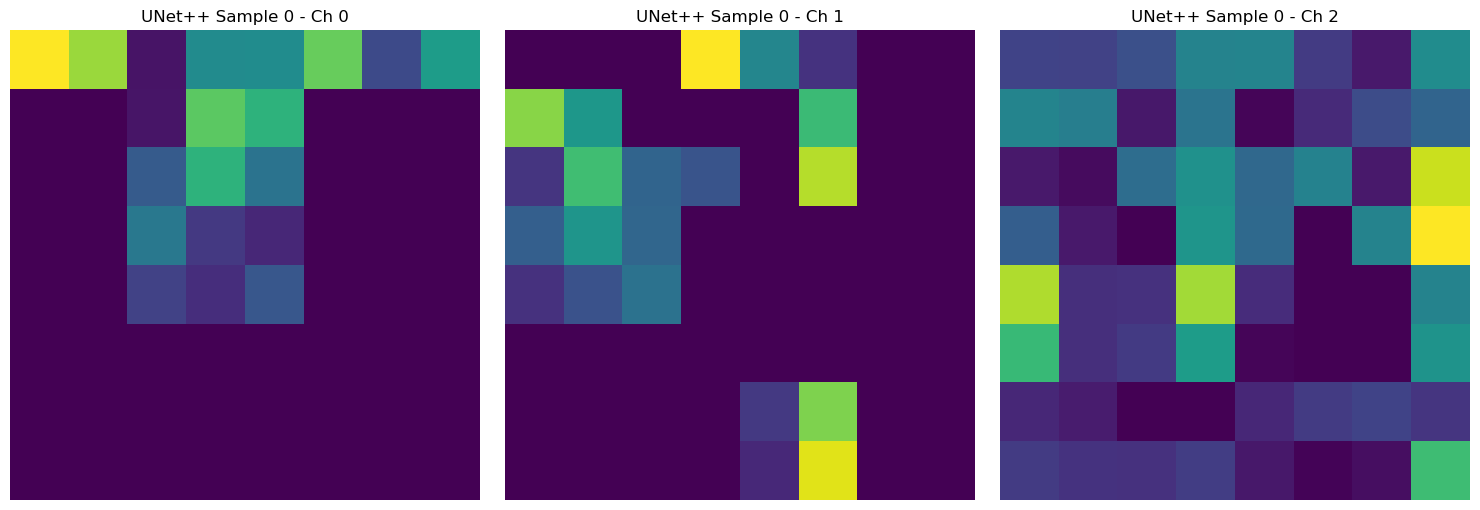

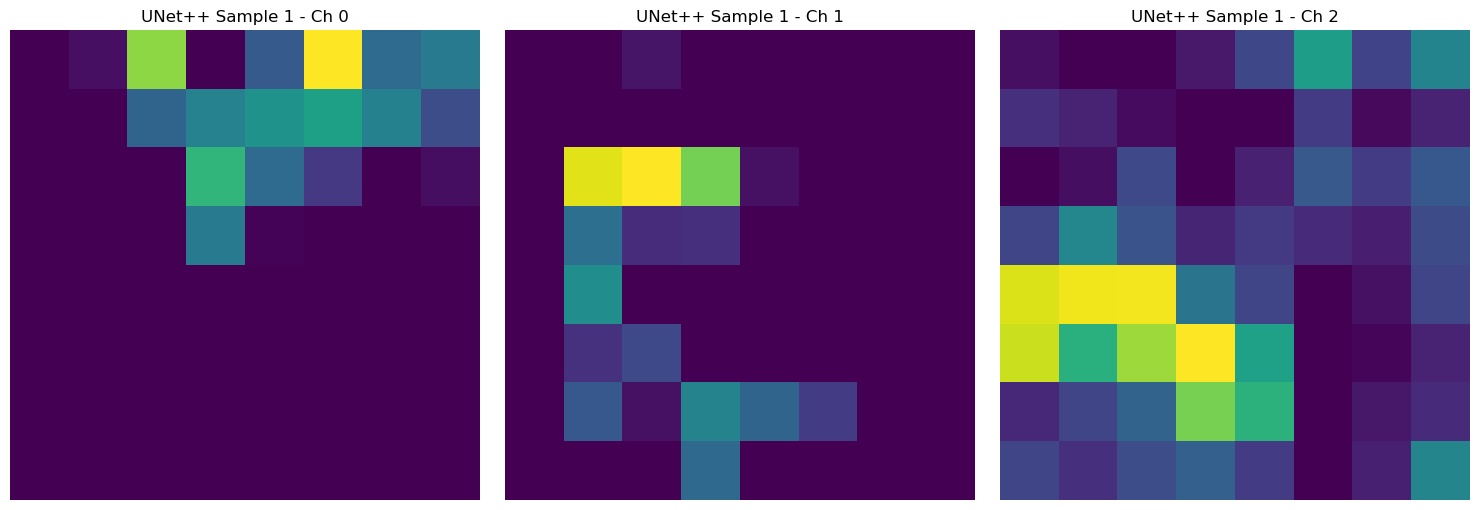

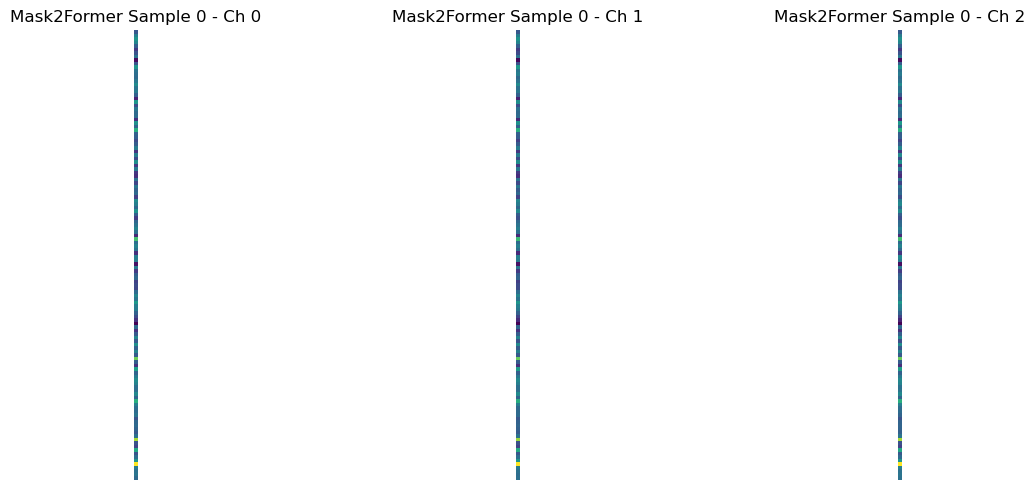

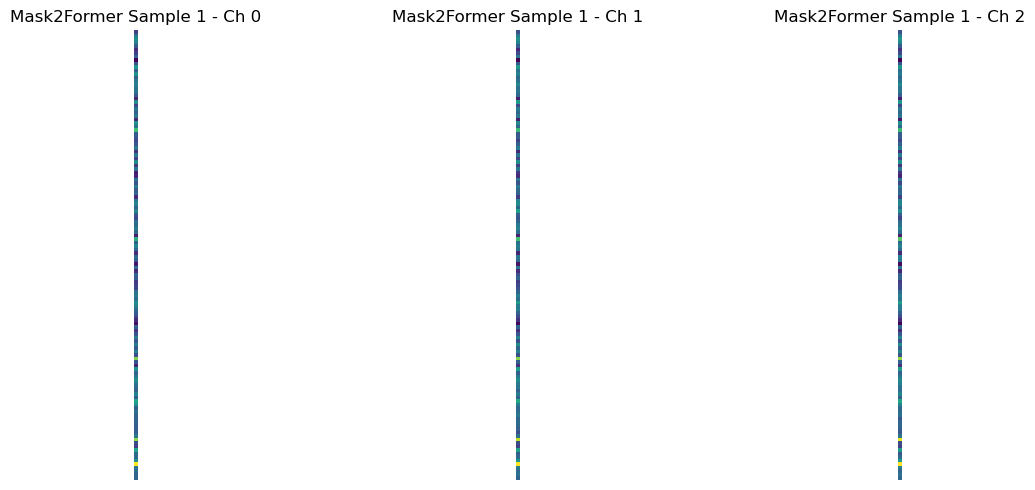

In [ ]:


#  Compare activation maps for a few samples and channels
compare_activation_maps(features_unet_small, features_mask2former_small,
                        layer_unet="encoder.layer3",
                        layer_mask2former="model.pixel_level_module.encoder.embeddings.norm",
                        sample_indices=[0, 1],  # visualize 2 samples
                        channels_to_show=[0, 1, 2])  # visualize 3 channels

Original shape: torch.Size([16, 1024, 128])
After PCA, shape: (16, 128, 3)
Reshaped for visualization: (16, 3, 8, 16)


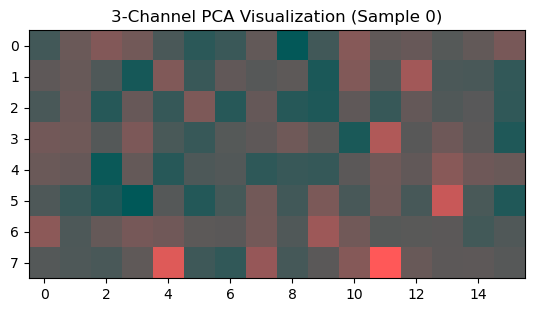

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Suppose features_mask2former_small is defined and contains your activations.
# For example, it might have shape [N, hidden_dim, seq_len]
acts_3d = features_mask2former_small['model.pixel_level_module.encoder.embeddings.norm']  # shape [N, hidden_dim, seq_len]
N, H_DIM, SEQ_LEN = acts_3d.shape
print("Original shape:", acts_3d.shape)

# 1) Flatten: rearrange to [N*seq_len, hidden_dim]
acts_flat = acts_3d.permute(0, 2, 1).reshape(-1, H_DIM)  # shape: [N*seq_len, hidden_dim]

# 2) PCA to 3 components
pca = PCA(n_components=3)
acts_pca = pca.fit_transform(acts_flat.cpu().numpy())  # shape: [N*seq_len, 3]

# 3) Reshape back: first, get N from the result (should match the original batch size)
N_new = int(acts_pca.shape[0] / SEQ_LEN)  # dynamically compute N
acts_pca = acts_pca.reshape(N_new, SEQ_LEN, 3)  # shape: [N_new, seq_len, 3]
print("After PCA, shape:", acts_pca.shape)

# 4) Suppose seq_len = 64 and you want an 8×8 patch grid.
h_patch, w_patch = 8, 16
assert h_patch * w_patch == SEQ_LEN, "Patch grid does not match sequence length."

acts_pca = acts_pca.reshape(N_new, h_patch, w_patch, 3)  # shape: [N_new, 8, 8, 3]

# 5) Transpose for visualization: convert to [N_new, 3, 8, 8]
acts_pca = np.transpose(acts_pca, (0, 3, 1, 2))
print("Reshaped for visualization:", acts_pca.shape)

# Now visualize sample 0
sample_0 = acts_pca[0]  # shape [3, 8, 8]
# Normalize for display
sample_0_norm = (sample_0 - sample_0.min()) / (sample_0.max() - sample_0.min() + 1e-6)
sample_0_norm = np.clip(sample_0_norm, 0, 1)

# imshow expects [H, W, 3], so transpose sample_0_norm to [8, 8, 3]
sample_0_norm = np.transpose(sample_0_norm, (1, 2, 0))
plt.imshow(sample_0_norm)
plt.title("3-Channel PCA Visualization (Sample 0)")
plt.show()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import torch

def pca_to_3_channels(acts, shape_2d=None, device="cpu"):
    """
    Apply PCA to reduce the feature dimension to 3 channels.

    acts: torch.Tensor or np.ndarray
          shape can be:
            - [N, C, H, W] (CNN)
            - [N, hidden_dim, seq_len] (Transformer)
          We'll flatten the feature dimension and reduce it to 3 via PCA.

    shape_2d: tuple (height, width), optional
              If acts is Transformer-based (N, hidden_dim, seq_len), we need
              to interpret seq_len as (height * width). For example, (8,16) for 128 tokens.

    returns: A np.ndarray with shape [N, 3, height, width]
             after PCA, we interpret the new dimension as 3 "channels."
    """

    # Convert to CPU numpy
    if isinstance(acts, torch.Tensor):
        acts = acts.to(device).detach().cpu().numpy()

    if acts.ndim == 4:
        # Case 1: CNN-like shape [N, C, H, W]
        N, C, H, W = acts.shape

        # Flatten to [N * H * W, C]
        acts_flat = np.transpose(acts, (0, 2, 3, 1))  # [N, H, W, C]
        acts_flat = acts_flat.reshape(-1, C)         # [N*H*W, C]

        # PCA
        pca = PCA(n_components=3)
        acts_pca = pca.fit_transform(acts_flat)      # [N*H*W, 3]

        # Reshape back to [N, H, W, 3]
        acts_pca = acts_pca.reshape(N, H, W, 3)
        # Transpose to [N, 3, H, W]
        acts_pca = np.transpose(acts_pca, (0, 3, 1, 2))
        return acts_pca

    elif acts.ndim == 3:
        # Case 2: Transformer-like shape [N, hidden_dim, seq_len]
        N, H_DIM, SEQ_LEN = acts.shape
        if shape_2d is None:
            raise ValueError("For a Transformer shape, you must provide shape_2d=(height, width) so we can reshape seq_len.")

        # Flatten to [N * seq_len, hidden_dim]
        acts_flat = np.transpose(acts, (0, 2, 1))   # [N, seq_len, hidden_dim]
        acts_flat = acts_flat.reshape(-1, H_DIM)    # [N*seq_len, hidden_dim]

        # PCA
        pca = PCA(n_components=3)
        acts_pca = pca.fit_transform(acts_flat)     # [N*seq_len, 3]

        # Reshape back: [N, seq_len, 3]
        N_new = acts_pca.shape[0] // SEQ_LEN
        acts_pca = acts_pca.reshape(N_new, SEQ_LEN, 3)

        # Now interpret seq_len as shape_2d
        h_patch, w_patch = shape_2d
        if h_patch * w_patch != SEQ_LEN:
            raise ValueError(f"seq_len={SEQ_LEN} does not match h_patch*w_patch={h_patch*w_patch}")

        # [N, h_patch, w_patch, 3]
        acts_pca = acts_pca.reshape(N_new, h_patch, w_patch, 3)
        # Transpose to [N, 3, h_patch, w_patch]
        acts_pca = np.transpose(acts_pca, (0, 3, 1, 2))
        return acts_pca

    else:
        raise ValueError(f"Unsupported shape {acts.shape}; must be 4D (CNN) or 3D (Transformer).")

In [ ]:
# Example usage:

# UNet++ activations, shape [N, C, H, W]
cnn_acts = features_unet_small["encoder.layer3"]  # e.g. [16, 64, 8, 8]
cnn_acts_pca = pca_to_3_channels(cnn_acts)  # shape [N, 3, 8, 8]

# Transformer activations, shape [N, hidden_dim, seq_len], e.g. [16, 1024, 128]
transformer_acts = features_mask2former_small["model.pixel_level_module.encoder.embeddings.norm"]
transformer_acts_pca = pca_to_3_channels(transformer_acts, shape_2d=(8,16))  # [N, 3, 8, 16]

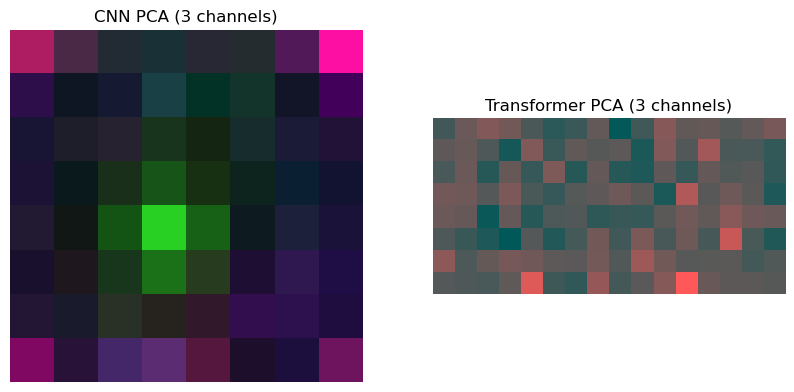

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def compare_3ch_maps(acts_cnn_3ch, acts_trans_3ch, sample_idx=0):
    """
    Compare two 3-channel activation maps side by side.
    acts_cnn_3ch: [N, 3, H, W]
    acts_trans_3ch: [N, 3, H', W']
    """
    cnn_img = acts_cnn_3ch[sample_idx]  # shape [3, H, W]
    trans_img = acts_trans_3ch[sample_idx]  # shape [3, H', W']

    def normalize_3ch(x):
        x_min, x_max = x.min(), x.max()
        return (x - x_min) / (x_max - x_min + 1e-6)

    cnn_img_norm = normalize_3ch(cnn_img)
    trans_img_norm = normalize_3ch(trans_img)

    # Transpose to [H, W, 3] for plotting
    cnn_img_norm = np.transpose(cnn_img_norm, (1, 2, 0))
    trans_img_norm = np.transpose(trans_img_norm, (1, 2, 0))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(cnn_img_norm)
    axs[0].set_title("CNN PCA (3 channels)")
    axs[0].axis("off")

    axs[1].imshow(trans_img_norm)
    axs[1].set_title("Transformer PCA (3 channels)")
    axs[1].axis("off")

    plt.show()

# Example call:
compare_3ch_maps(cnn_acts_pca, transformer_acts_pca, sample_idx=0)